# Analysis of distribution of shape statistics

This notebook uses indices capturing relationship between shape metrics and area of polygons across all FUAs, identifies peaks and valleys in the distribution using KDE and assesses performance of each shape metric in distinguishing between face polygons and face artifacts.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import pickle
import geopandas
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6

from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

Set default plotting theme and add color dictionary for continents.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

coldict = {
    'Africa': 0, 
    'Asia': 1, 
    'Europe': 2, 
    'North America': 3, 
    'Oceania': 4, 
    'South America': 5}

Load the data and combine them to a single GeoDataFrame.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

all_poly = []
for i, row in sample.iterrows():
    fua = geopandas.read_parquet(f"../data/{int(row.eFUA_ID)}/polygons/")
    fua["continent"] = row.continent
    fua["country"] = row.Cntry_name
    fua["name"] = row.eFUA_name
    fua.crs = None
    all_poly.append(fua)
all_poly_data = pandas.concat(all_poly).reset_index(drop=True)


Set parameters and options for PDF estimation and peak finding; then, generate kernel density estimation (KDE) function for each FUA and each shape metric. Save local minima and maxima ("peaks" and "valleys"), their locations and probability density functions for further analysis.

In [4]:
# set parameters
options = [
    "circular_compactness_index",
    "isoperimetric_quotient_index",
    "isoareal_quotient_index",
    "radii_ratio_index",
    "diameter_ratio_index",
]

# parameter for pdf fitting
npoints = 1000

# parameters for peak/valley finding
peak_parameters = {
    "height_mins": numpy.NINF, # no minimal/maximal height for local minima of f (i.e. for peaks of 1-f); setting minimum height to negative inf to nevertheless obtain y-axis peak heights from function
    "height_maxs": 0.008, # minimal height for local maxima of f, to exclude noise; but no maximal height for those peaks
    "prominence": 0.00075} 

In [5]:
# local minima/maxima of KDEs for each FUA and each metric

results = {}

for city in all_poly_data.name.unique():

    # to store results
    results[city] = {}

    # filter for data of only this city
    fua = all_poly_data[all_poly_data.name == city]

    for option in options:
                
        # to store results
        results[city][option] = {}

        # get data for current option, using log of data
        data = numpy.log(fua[option])
        
        # fit Gaussian KDE
        kde = gaussian_kde(data, bw_method="silverman")
        
        # define linear space
        mylinspace = numpy.linspace(data.min(), data.max(), npoints)

        # generate probability density function
        pdf = kde.pdf(mylinspace)

        # find peaks
        peaks, d_peaks = find_peaks(
            x = pdf,
            height = peak_parameters["height_maxs"],
            threshold = None,
            distance = None,
            prominence = peak_parameters["prominence"],
            width = 1,
            plateau_size = None)

        # find valleys
        valleys, d_valleys = find_peaks(
            x = -pdf + 1,
            height = peak_parameters["height_mins"],
            threshold = None,
            distance = None,
            prominence = peak_parameters["prominence"],
            width = 1,
            plateau_size = None)
        
        # store results
        results[city][option]["linspace_params"] = {
            "start": data.min(),
            "stop": data.max(),
            "num": npoints}
        results[city][option]["pdf"] = pdf
        results[city][option]["peaks"] = peaks
        results[city][option]["d_peaks"] = d_peaks
        results[city][option]["valleys"] = valleys
        results[city][option]["d_valleys"] = d_valleys

Now, for each FUA and each metric, check whether the following conditions are fulfilled:
* At least 2 peaks have been found
* At least 1 valley has been found
* There is a peak to the left of the highest peak (i.e. the highest peak is *not* the first peak)
* There is a valley between the highest peak and the left-of-highest peak

If all these conditions are fulfilled, we identify the artefact threshold for the given FUA and given metric as the location of the valley to the left of the highest peak. In case this threshold has been found, we also quantify its power by computing the vertical distance between the highest peak and the valley to its left.

In [6]:
for city in all_poly_data.name.unique():

    for option in options:

        # initially, set threshold and threshold_distance to False
        results[city][option]["threshold"] = False
        results[city][option]["threshold_distance"] = False

        # check if we have at least 2 peaks and at least 1 valley; 
        # also check that the highest peak is not the first one
        if len(results[city][option]["peaks"]) > 1 and len(results[city][option]["valleys"]) > 0 and numpy.argmax(results[city][option]["d_peaks"]["peak_heights"]) > 0:

            # check whether there is exactly one valley between highest and left-from-highest peak
            highest_peak_listindex = numpy.argmax(results[city][option]["d_peaks"]["peak_heights"])

            highest_peak_index = results[city][option]["peaks"][highest_peak_listindex]
            left_peak_index = results[city][option]["peaks"][highest_peak_listindex-1]

            valley_indices = results[city][option]["valleys"]
            valley_indices_between_peaks = (valley_indices > left_peak_index) & (valley_indices < highest_peak_index)
            
            if valley_indices_between_peaks.sum()==1:

                valley_index = int(valley_indices[valley_indices_between_peaks])

                # recreate linear space that our indeces refer to
                mylinspace = numpy.linspace(
                    start = results[city][option]["linspace_params"]["start"], 
                    stop = results[city][option]["linspace_params"]["stop"], 
                    num = results[city][option]["linspace_params"]["num"])
                # derive threshold value for given option from index/linspace
                my_threshold = float(numpy.exp(mylinspace[valley_index]))

                results[city][option]["threshold"] = my_threshold

                # compute vertical (y-axis) distance between peak and valley to express power of metric
                mypeak = results[city][option]["d_peaks"]["peak_heights"][highest_peak_listindex]
                myvalley = 1-results[city][option]["d_valleys"]["peak_heights"][valley_indices_between_peaks]
                mydist = mypeak - myvalley
                results[city][option]["threshold_distance"] = mydist



Luohe
circular_compactness_index
Luohe
isoperimetric_quotient_index
Luohe
isoareal_quotient_index
Luohe
radii_ratio_index
Luohe
diameter_ratio_index
Lucknow
circular_compactness_index
Lucknow
isoperimetric_quotient_index
Lucknow
diameter_ratio_index
Jaipur
circular_compactness_index
Jaipur
diameter_ratio_index
Aleppo
circular_compactness_index
Aleppo
isoperimetric_quotient_index
Xingtai
isoareal_quotient_index
Tbilisi
circular_compactness_index
Tbilisi
isoperimetric_quotient_index
Tbilisi
isoareal_quotient_index
Tbilisi
radii_ratio_index
Tbilisi
diameter_ratio_index
Mandalay
circular_compactness_index
Mandalay
diameter_ratio_index
Kabul
circular_compactness_index
Kabul
isoperimetric_quotient_index
Kabul
diameter_ratio_index
Basra
circular_compactness_index
Basra
isoperimetric_quotient_index
Basra
diameter_ratio_index
Seoul
circular_compactness_index
Agra
circular_compactness_index
Jombang
diameter_ratio_index
Semarang
circular_compactness_index
Accra
circular_compactness_index
Accra
is

Save all results so far

In [8]:
with open('../results/04_peaks_results.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../results/04_peaks_results.pickle', 'rb') as handle:
#     results = pickle.load(handle)

****
### Compare peak results for different metrics
Brief visual assessment: which metric is most successful at identifying a threshold for each FUA? 

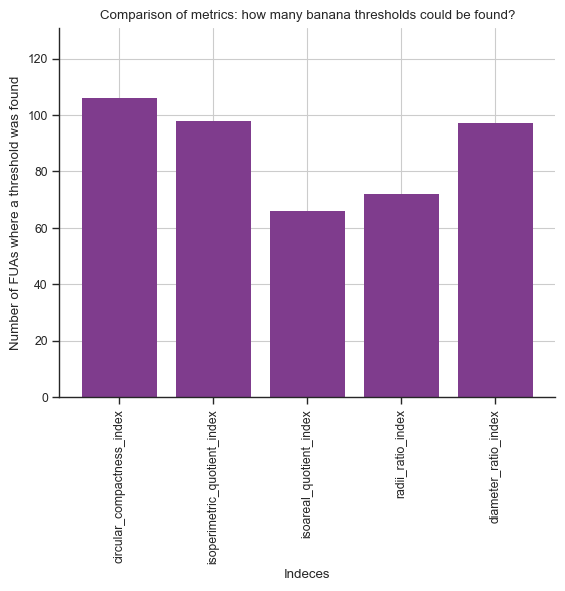

In [9]:
thresholds_found = [sum([results[city][option]["threshold"] != False for city in results.keys()]) for option in options]
plt.bar(x = options, height = thresholds_found)
plt.ylim((0,len(results.keys())))
plt.xticks(rotation = 90)
plt.xlabel("Indeces")
plt.ylabel("Number of FUAs where a threshold was found")
plt.title("Comparison of metrics: how many banana thresholds could be found?");

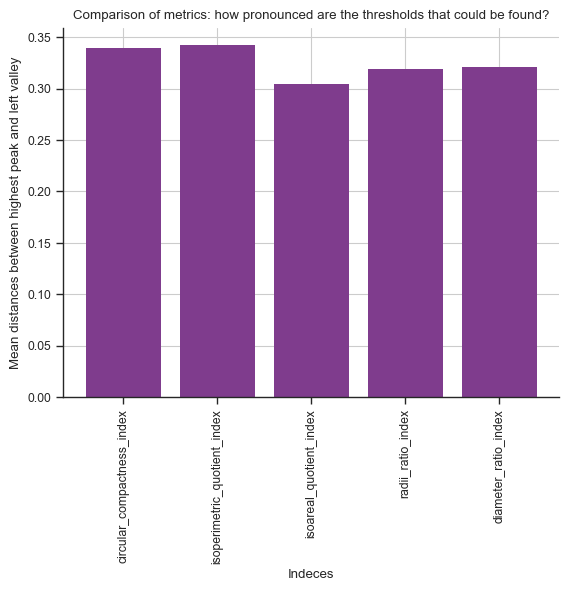

In [10]:
mean_distances_found = [numpy.average([results[city][option]["threshold_distance"] for city in results.keys() if results[city][option]["threshold_distance"] != False]) for option in options]
plt.bar(x = options, height = mean_distances_found)
#plt.ylim((0,1))
plt.xticks(rotation = 90)
plt.xlabel("Indeces")
plt.ylabel("Mean distances between highest peak and left valley")
plt.title("Comparison of metrics: how pronounced are the thresholds that could be found?");

***
### Plot peak results for all 5 metrics

In [11]:
os.makedirs("../plots/peak_options", exist_ok=True)

for city in all_poly_data.name.unique():
    
    # initiate plot
    fig, ax = plt.subplots(1,5,figsize = (20,5))

    # get continent color from dict
    continent = numpy.max(all_poly_data[all_poly_data["name"]==city].continent)
    continent_color = sns.color_palette(n_colors = 6)[coldict[continent]]

    for i, option in enumerate(options):
        
        my_pdf = results[city][option]["pdf"]
        
        # plot vlines at identified peak (local max) points
        ax[i].vlines(
            x = results[city][option]["peaks"],
            ymin=0,
            ymax=1,
            colors=continent_color,
            linestyles="dotted",
            alpha = 1,
            linewidth = 1
            )

        # plot vlines at identified valley (local min) points
        ax[i].vlines(
            x = results[city][option]["valleys"],
            ymin=0,
            ymax=1,
            colors=continent_color,
            linestyles="dotted",
            alpha = 1,
            linewidth = 1
            )
        
        # plot pdf
        ax[i].plot(my_pdf, color = "grey")
        
        # add scatter points at pdf/vline intersections
        ax[i].scatter(
                    x = results[city][option]["peaks"], 
                    y = my_pdf[results[city][option]["peaks"]], 
                    color = continent_color, 
                    s = 8, 
                    alpha = 1);
        ax[i].scatter(
                    x = results[city][option]["valleys"], 
                    y = my_pdf[results[city][option]["valleys"]], 
                    color = continent_color, 
                    s = 8, 
                    alpha = 1);
        ax[i].set_xlabel(option)
        ax[i].set_ylim([0,1])

    plt.suptitle(city);

    fig.savefig(f"../plots/peak_options/{city}.png", dpi = 400)
    plt.close()


***
### Plot peak results for circular compactness index

In [12]:
os.makedirs("../plots/circular_compactness_index/", exist_ok=True)

for city in all_poly_data.name.unique():
    
    # initiate plot
    fig, ax = plt.subplots(1,1,figsize = (10,10))

    # get continent color from dict
    continent = numpy.max(all_poly_data[all_poly_data["name"]==city].continent)
    continent_color = sns.color_palette(n_colors = 6)[coldict[continent]]

    option = "circular_compactness_index"

    my_pdf = results[city][option]["pdf"]
        
    # plot vlines at identified peak (local max) points
    ax.vlines(
        x = results[city][option]["peaks"],
        ymin=0,
        ymax=1,
        colors=continent_color,
        linestyles="dotted",
        alpha = 1,
        linewidth = 1
        )

    # plot vlines at identified valley (local min) points
    ax.vlines(
        x = results[city][option]["valleys"],
        ymin=0,
        ymax=1,
        colors=continent_color,
        linestyles="dotted",
        alpha = 1,
        linewidth = 1
        )
    
    # plot pdf
    ax.plot(my_pdf, color = "grey")
    
    # add scatter points at pdf/vline intersections
    ax.scatter(
                x = results[city][option]["peaks"], 
                y = my_pdf[results[city][option]["peaks"]], 
                color = continent_color, 
                s = 8, 
                alpha = 1);
    ax.scatter(
                x = results[city][option]["valleys"], 
                y = my_pdf[results[city][option]["valleys"]], 
                color = continent_color, 
                s = 8, 
                alpha = 1);
    ax.set_xlabel(option)
    ax.set_ylim([0,1])

    plt.suptitle(city);
    fig.savefig(f"../plots/circular_compactness_index/{city}.png", dpi = 400)
    plt.close()


***
### Replicate results from large loop above for one single city.

Define city and option (metric)

In [17]:
city = "Moscow"
option = "circular_compactness_index"

Compute KDE and its peaks/valleys

In [18]:
# get data for current option, using log of data
data = numpy.log(fua[option])

# fit Gaussian KDE
kde = gaussian_kde(data, bw_method="silverman")

# define linear space
mylinspace = numpy.linspace(data.min(), data.max(), npoints)

# generate probability density function
pdf = kde.pdf(mylinspace)

# find peaks
peaks, d_peaks = find_peaks(
    x = pdf,
    height = peak_parameters["height_maxs"],
    threshold = None,
    distance = None,
    prominence = peak_parameters["prominence"],
    width = 1,
    plateau_size = None)

# find valleys
valleys, d_valleys = find_peaks(
    x = -pdf + 1,
    height = peak_parameters["height_mins"],
    threshold = None,
    distance = None,
    prominence = peak_parameters["prominence"],
    width = 1,
    plateau_size = None)

Check if threshold conditions are satisfied

In [19]:
# check if we have at least 2 peaks and at least 1 valley; 
# also check that the highest peak is not the first one
if len(peaks) > 1 and len(valleys) > 0 and numpy.argmax(d_peaks["peak_heights"]) > 0:

    # check whether there is exactly one valley between highest and left-from-highest peak
    highest_peak_listindex = numpy.argmax(d_peaks["peak_heights"])

    highest_peak_index = peaks[highest_peak_listindex]
    left_peak_index = peaks[highest_peak_listindex-1]

    valley_indices = valleys
    valley_indices_between_peaks = (valley_indices > left_peak_index) & (valley_indices < highest_peak_index)
    
    if valley_indices_between_peaks.sum()==1:

        valley_index = int(valley_indices[valley_indices_between_peaks])

        # recreate linear space that our indeces refer to
        mylinspace = numpy.linspace(
            start = data.min(), 
            stop = data.max(), 
            num = npoints)
        # derive threshold value for given option from index/linspace
        my_threshold = float(numpy.exp(mylinspace[valley_index]))

        # compute vertical (y-axis) distance between peak and valley to express power of metric
        mypeak = results[city][option]["d_peaks"]["peak_heights"][highest_peak_listindex]
        myvalley = 1-results[city][option]["d_valleys"]["peak_heights"][valley_indices_between_peaks]
        mydist = mypeak - myvalley
        results[city][option]["threshold_distance"] = mydist

if my_threshold:
    print(f"Threshold found for {city} for {option}: {my_threshold}")
else:
    print(f"No threshold found for {city} for {option}")


Threshold found for Moscow for circular_compactness_index: 1094.532008542304


Make plot of KDE with peaks and valleys

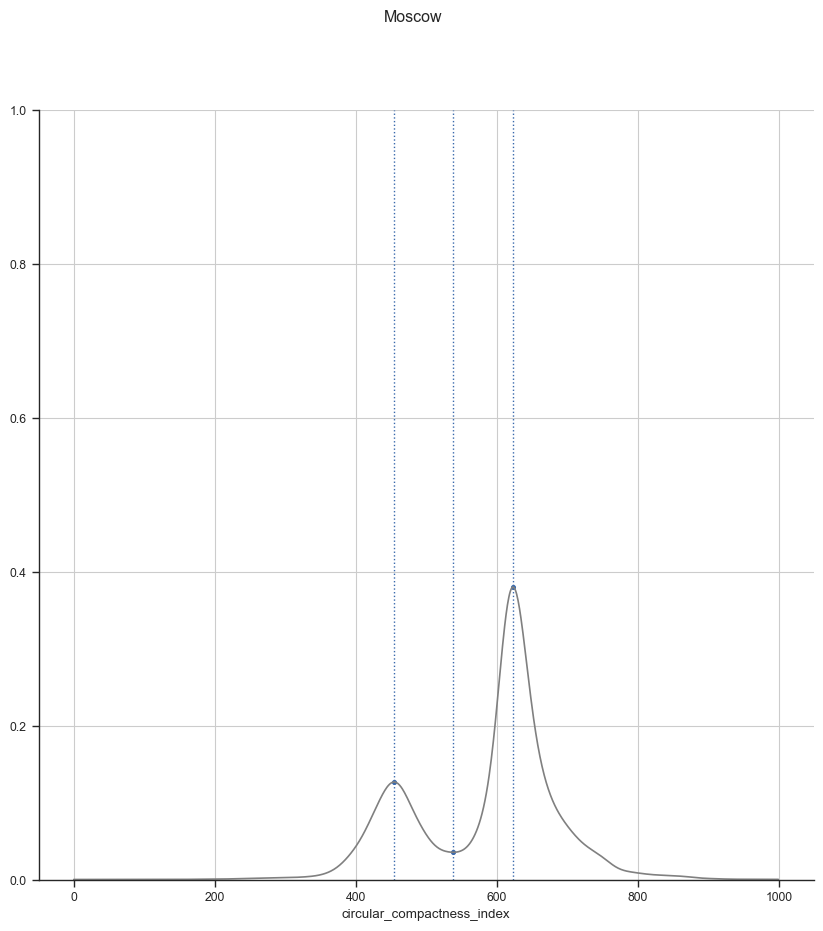

In [20]:
# initiate plot
fig, ax = plt.subplots(1,1,figsize = (10,10))

# get continent color from dict
continent = numpy.max(all_poly_data[all_poly_data["name"]==city].continent)
continent_color = sns.color_palette(n_colors = 6)[coldict[continent]]

my_pdf = pdf
    
# plot vlines at identified peak (local max) points
ax.vlines(
    x = peaks,
    ymin=0,
    ymax=1,
    colors=continent_color,
    linestyles="dotted",
    alpha = 1,
    linewidth = 1
    )

# plot vlines at identified valley (local min) points
ax.vlines(
    x = valleys,
    ymin=0,
    ymax=1,
    colors=continent_color,
    linestyles="dotted",
    alpha = 1,
    linewidth = 1
    )

# plot pdf
ax.plot(my_pdf, color = "grey")

# add scatter points at pdf/vline intersections
ax.scatter(
            x = peaks, 
            y = my_pdf[peaks], 
            color = continent_color, 
            s = 8, 
            alpha = 1);
ax.scatter(
            x = valleys, 
            y = my_pdf[valleys], 
            color = continent_color, 
            s = 8, 
            alpha = 1);
ax.set_xlabel(option)
ax.set_ylim([0,1])

plt.suptitle(city);